In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, GRU, MultiHeadAttention
import yfinance as yf

import os


pd.options.mode.copy_on_write = True
data_dir = 'data'

In [2]:
def get_data(ticker_or_tickers, start_date=None, end_date=None):
    data = yf.download(ticker_or_tickers, start=start_date, end=end_date)
    return data

In [3]:
fresh_data = get_data('INTC', '2020-01-01', '2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [28]:
fresh_data = get_data(['NVDA', 'TSM', 'INTC', 'AAPL', 'IBM', 'CSCO', 'AMD', 'MSFT'])


[*********************100%%**********************]  8 of 8 completed


In [4]:
data = fresh_data.dropna()
data = data.head(1000)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
# original_shape = data['Close'].values.shape
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
# scaled_data = scaled_data.reshape(original_shape)

# Create the training dataset
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create the sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 50
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [30]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6350, 50, 1), (6350, 1), (1550, 50, 1), (1550, 1))

In [13]:
# Build the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    MultiHeadAttention(num_heads=2, key_dim=2, value_dim=2),
    GRU(50, return_sequences=True, activation='relu'),
    GRU(50, return_sequences=False, activation='relu'),
    Dense(50, activation='relu'),
    # Dense(50, activation='relu'),
    # Dense(25, activation='relu'),
    Dense(15, activation='relu'),
    Dense(1)
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


ValueError: Layers added to a Sequential model can only have a single positional argument, the input tensor. Layer MultiHeadAttention has multiple positional arguments: [<Parameter "query">, <Parameter "value">]

In [6]:
from tensorflow.keras.utils import plot_model

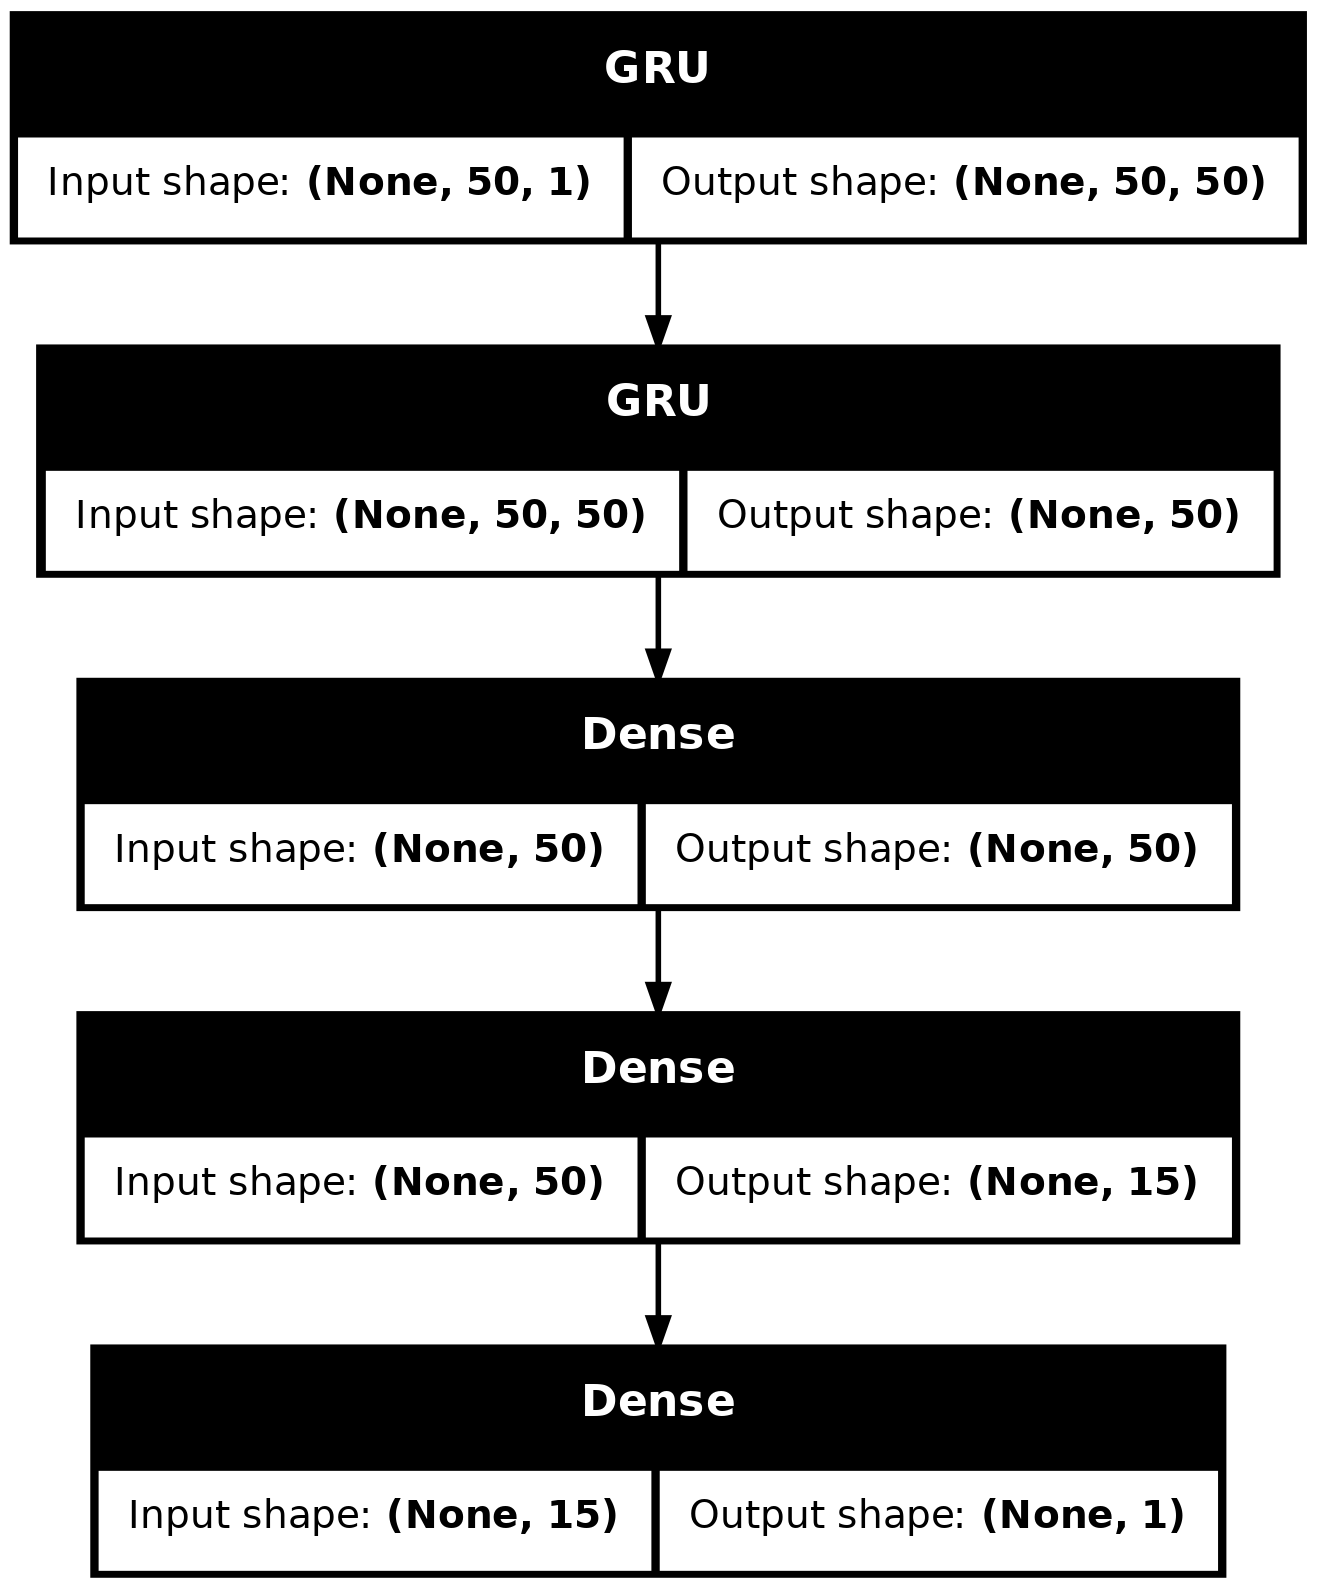

In [7]:
plot_model(model, show_shapes=True)

In [ ]:
# Train the model
model.fit(X_train, y_train, batch_size=100, epochs=10)

# Evaluate the model
predictions = model.predict(X_test)

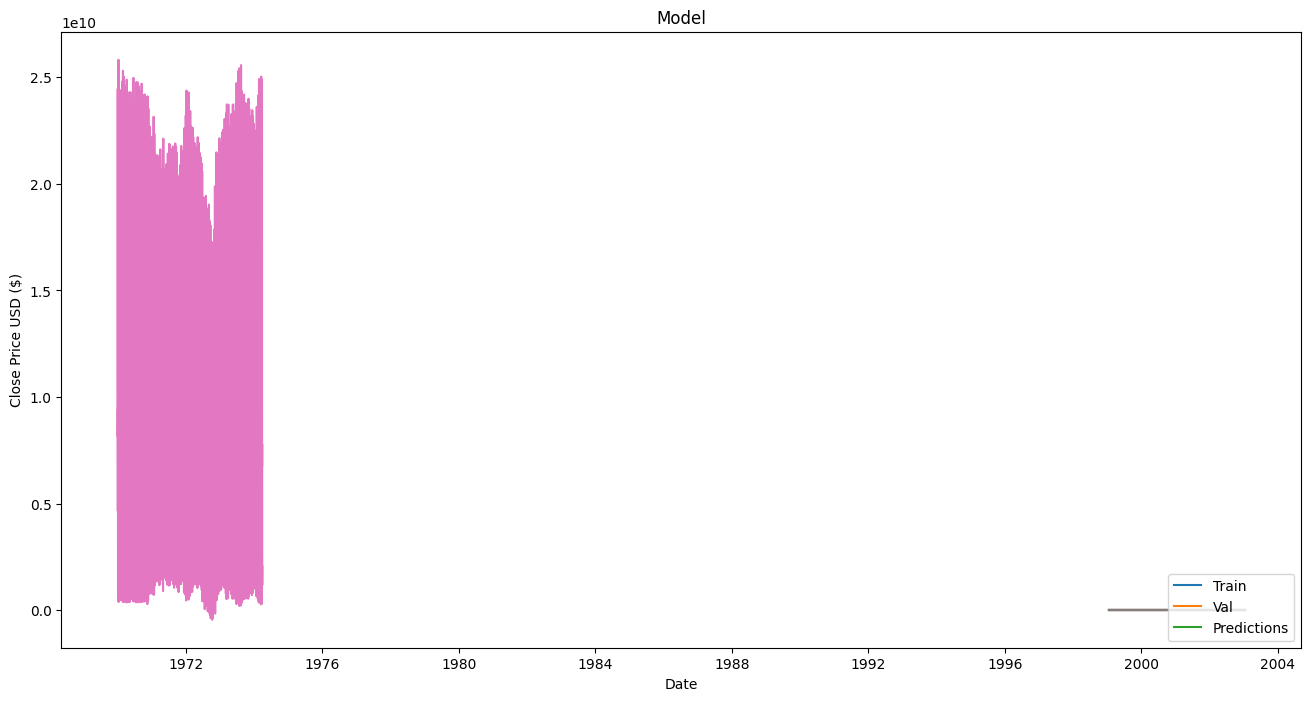

In [37]:
predictions = scaler.inverse_transform(predictions)
# predictions = predictions.reshape(predictions_shape)

# Prepare the data for plotting
train = data[:train_size]
valid = data[train_size + sequence_length:]  # Adjust for sequence length offset
valid['Predictions'] = predictions.flatten()

# Plot the results
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show() 

In [35]:
predictions.shape

(1550, 1)

In [52]:
help(scaler.inverse_transform)

Help on method inverse_transform in module sklearn.preprocessing._data:

inverse_transform(X) method of sklearn.preprocessing._data.MinMaxScaler instance
    Undo the scaling of X according to feature_range.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input data that will be transformed. It cannot be sparse.
    
    Returns
    -------
    Xt : ndarray of shape (n_samples, n_features)
        Transformed data.



In [5]:
# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Build the model
model = Sequential([
    Flatten(input_shape=(28, 28)),  # Flatten the 28x28 images into a 1D vector
    Dense(128, activation='relu'),  # First hidden layer with 128 neurons and ReLU activation
    Dense(64, activation='relu'),   # Second hidden layer with 64 neurons and ReLU activation
    Dense(10, activation='softmax') # Output layer with 10 neurons for 10 classes and softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

/home/someusername/projects/FinanceTools/env/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-06-02 16:11:50.524602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-02 16:11:50.525441: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required librari

Epoch 1/10


2024-06-02 16:11:50.678207: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


AttributeError: module 'keras.src.backend' has no attribute 'convert_to_numpy'